# Simulación 3

Decaimiento nuclear usando la distribución de Poisson


## Previo

Se importan los paquetes


In [2]:
import numpy as np
from scipy.stats import poisson, norm
import matplotlib as mpl
import matplotlib.pyplot as plt

Se configuran las gráficas, tengase en cuenta que algunos pueden no cargar por dependencias a instalar pendientes.


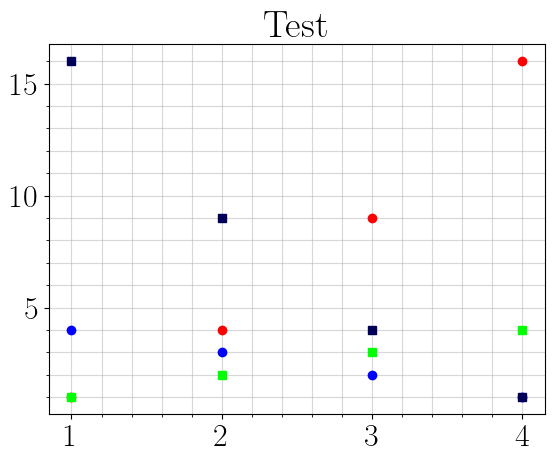

In [3]:
# plt.style.use("seaborn-v0_8-bright")
mpl.rcParams.update(
    {
        "legend.fontsize": 23,
        "axes.labelsize": 23,
        "xtick.labelsize": 23,
        "ytick.labelsize": 23,
        "text.usetex": True,
        "font.family": "Times New Roman",
        "mathtext.fontset": "dejavusans",
        "font.size": 23,
        "axes.grid": True,
        "grid.alpha": 0.5,
        "grid.linestyle": "-",
        "xtick.minor.visible": True,
        "ytick.minor.visible": True,
        "axes.grid.which": "both",
    }
)

def plot_template(title, x_label, y_label, x_lim=None, y_lim=None):
    """Genera la plantilla de graficación para mantener consistencia en el formato de cada gráfica única generada.

    Args:
        title (string): Aplica titulos.
        x_label (string): Título de eje x.
        y_label (string): Título de eje y.
        x_lim ([float], optional): Límite en eje x. Defaults to None.
        y_lim ([float], optional): Límite en eje y. Defaults to None.

    Returns:
        object: Devuelve los objetos de la gráfica modificados con la plantilla requerida
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_title(title, fontsize=18)
    ax.set_xlabel(x_label, fontsize=16)
    ax.set_ylabel(y_label, fontsize=16)
    if x_lim is not None:
        ax.set_xlim(x_lim)
    if y_lim is not None:
        ax.set_ylim(y_lim)
    ax.grid(True, which="both", linestyle="--", alpha=0.7)
    fig.tight_layout()
    return fig, ax


# Set a custom color cycle (palette)
colors_gasbley = [
    "#ff0000", "#0000ff", "#00ff00", "#000058", "#942100", "#ff0092", "#006500", "#e5be01",
    "#ffd300", "#968000", "#ff0073", "#24007b", "#009292", "#c10087", "#1478e5", "#bea281",
    "#00ffc5", "#ff0000", "#7b0046", "#8c6640", "#01fffe", "#09007b", "#6e5300", "#825cdb",
    "#ac82ff", "#56ff7b", "#02ad23", "#8176d1", "#c87cff", "#70929b", "#ff9000", "#c248c0"
]
ditto_seq_colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
    '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f78b4', '#33a02c',
    '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a',
    '#ffff99', '#b15928', '#8dd3c7', '#ffffb3', '#bebada', '#fb8072',
    '#80b1d3', '#fdb462', '#b3de69', '#fccde5', '#d9d9d9', '#bc80bd', 
    '#ccebc5', '#ffed6f'
]

# Configuracion de colores
k = 0
colors = colors_gasbley

# Rotar la lista: número positivo para rotar a la derecha, negativo para rotar a la izquierda
colors = colors[-k:] + colors[:-k]

plt.rcParams["axes.prop_cycle"] = plt.cycler(color=colors)

# Test
if True:
    plt.plot([1, 2, 3, 4], [1, 4, 9, 16], "o")
    plt.plot([4, 3, 2, 1], [1, 2, 3, 4], "o")
    plt.plot([1, 2, 3, 4], [1, 2, 3, 4], "s")
    plt.plot([4, 3, 2, 1], [1, 4, 9, 16], "s")
    plt.title("Test")
    plt.show()

## 1. Simulación Base


Se verifica el comportamiento de la subrutina

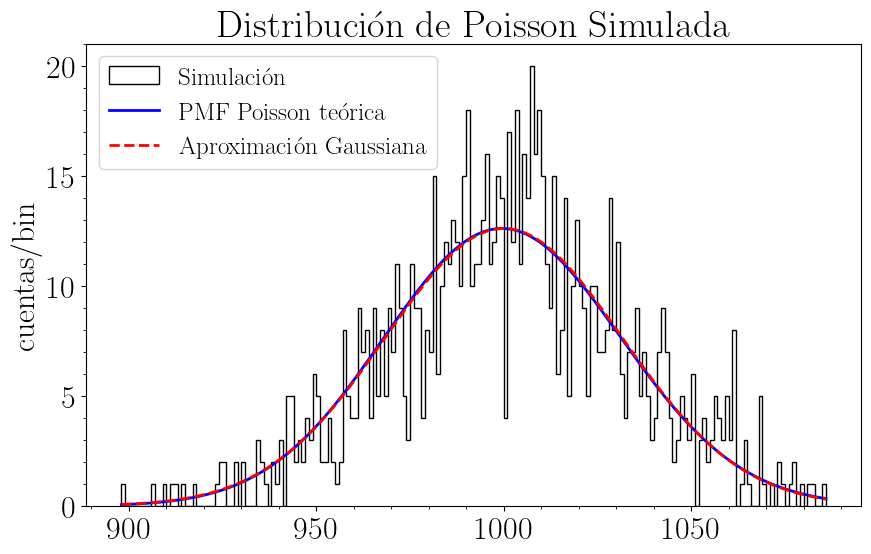

In [4]:
# Parameters
mu = 1000
N = 1000

# Generate Poisson distributed random variables
data = [poisson.rvs(mu, size=1) for i in range(N)]
data = np.concatenate(data)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Create histogram of the random variables
ax.hist(
    data,
    bins=range(min(data), max(data) + 1),
    alpha=1,
    histtype="step",
    fill=False,
    label="Simulación",
    color="black",
)

# Calculate Poisson pmf
x = np.arange(min(data), max(data) + 1)
pmf = N * poisson.pmf(x, mu)


# Plot the theoretical distribution
ax.plot(x, pmf, "blue", lw=2, label="PMF Poisson teórica")

# Plot gaussian distribution for comparison
gaussian = norm.pdf(x, mu, np.sqrt(mu)) * N
ax.plot(
    x, gaussian, "red", lw=2, label="Aproximación Gaussiana", linestyle="--"
)

# Add labels and title
ax.set_ylabel("cuentas/bin")
ax.set_title("Distribución de Poisson Simulada")
ax.legend(fontsize=18)
ax.grid(False, which="both")

# Show plot
plt.show()

Recordar que la probabilidad individual de decaimiento es dada por el factor $\Gamma$ como

$$\Gamma = \frac{p}{\Delta t}$$

Sabiendo la relación $\Gamma = 1 / \tau$, resulta

$$p = \frac{\Delta t}{\tau}$$


In [5]:
def poisson_decay(N0, tau, delta_t):
    r"""
    Simula el decaimiento nuclear usando la distribución de Poisson.

    Args:
        N0 (int): Número inicial de núcleos
        delta_t (float): Intervalo de tiempo :math:`\Delta t`.
        tau (float): Tiempo de vida medio de los núcleos :math:`\tau`.

    Returns:
        t_values: Tiempos :math:`t_i` en los que se evalúa la actividad.
        A_values: Actividad :math:`A(t_i)` en los tiempos :math:`t_i`.
        N_values: Número de núcleos restantes :math:`N(t_i)` en los tiempos :math:`t_i`.
        pmf_values: Distribuciones de probabilidad de Poisson en cada paso :math:`P_p(x)`.
        cdf_values: Funciones acumulativas de Poisson en cada paso :math:`F(x)`.
    """
    t_values = []
    A_values = []
    N_values = []
    pmf_values = []  # Para guardar la función de masa de probabilidad
    cdf_values = []  # Para guardar la función acumulativa

    N_t = N0
    t = 0

    while N_t > 0:
        # Calcular media de distribución Poisson
        mu = N_t * (delta_t / tau)

        # Generar número de decaimientos usando Poisson
        X = poisson.rvs(mu=mu)

        # Calcular actividad
        A_t = X / delta_t

        # Calcular PMF y CDF
        x = np.arange(0, N_t + 1)
        pmf = poisson.pmf(x, mu=mu)
        cdf = poisson.cdf(x, mu=mu)

        # Guardar valores para gráficos
        t_values.append(t)
        A_values.append(A_t)
        N_values.append(N_t)
        pmf_values.append(pmf)
        cdf_values.append(cdf)

        # Actualizar el número de núcleos restantes y el tiempo
        N_t -= X
        t += delta_t

    return (
        np.array(t_values),
        np.array(A_values),
        np.array(N_values),
        pmf_values,
        cdf_values,
    )


# test
if False:
    ps = poisson_decay(N0=1000, delta_t=1, tau=10)
    plt.plot(ps[0], ps[1], label="Actividad")

Se genera la visualización para **T4** donde $N(0) = 100, para el tiempo inicial $t_0 = 0$ y tiempo intermedio $t_m = (t_f - t_o)/2$. Primero se grafican las figuras básicas para corroborar el comportamiento deseado.


### Juntas

requiere un delta t mayor debido a que la actividad no se notaría, siempre es conveniente algo mayor

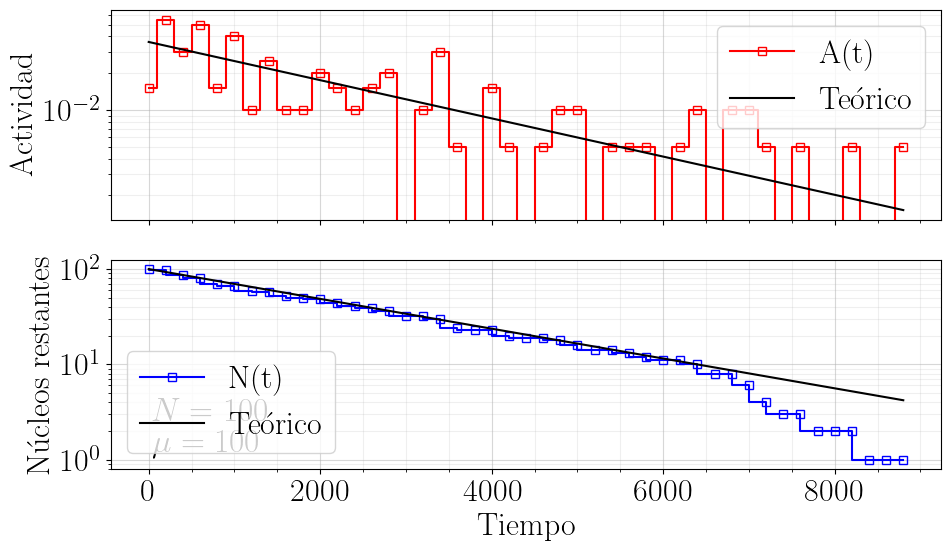

In [6]:
# Parámetros iniciales
N0 = 100  # Número inicial de núcleos
tau = 2775.68  # Tiempo de vida medio (arbitrario)
delta_t = 200  # Intervalo de tiempo

# Ejecutar la simulación
times, activities, nuclei_remaining, pmf_values, cdf_values = poisson_decay(
    N0, tau, delta_t
)

# Graficar resultados
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 6))

# Gráfico de la actividad
ax[0].plot(times, activities, label="A(t)", marker="s", fillstyle="none", ds="steps-mid")
# Comparar con la curva teórica de actividad
theoretical_activity = N0 / tau * np.exp(-np.array(times) / tau)
ax[0].plot(times, theoretical_activity, label="Teórico", linestyle="-", color="black")
ax[0].set_ylabel("Actividad")
ax[0].set_yscale("log")
ax[0].legend()
ax[0].grid(True, which="minor", alpha=0.2)

# Gráfico del número de núcleos restantes con color diferente
ax[1].plot(
    times,
    nuclei_remaining,
    label="N(t)",
    marker="s",
    fillstyle="none",
    color=colors[1],
    ds="steps",
)
# Comparar con la curva teórica de disminución exponencial
theoretical_decay = N0 * np.exp(-np.array(times) / tau)
ax[1].plot(times, theoretical_decay, label="Teórico", linestyle="-", color="black")
ax[1].set_xlabel("Tiempo")
ax[1].set_ylabel("Núcleos restantes")
ax[1].set_yscale("log")
ax[1].legend()
ax[1].grid(True, which="minor", alpha=0.2)

# Add text to the second plot
ax[1].text(0.05, 0.05, r"$\mu = 100$", transform=ax[1].transAxes, fontsize=24, verticalalignment='bottom')
ax[1].text(0.05, 0.2, r"$N = 100$", transform=ax[1].transAxes, fontsize=24, verticalalignment='bottom')

plt.subplots_adjust(hspace=0)  # Ajustar el espacio entre subplots

fig.tight_layout()
fig.savefig("T4_nuclear_decay.png", dpi=300)
plt.show()


### Separadas


Para Actividad $A(t)$

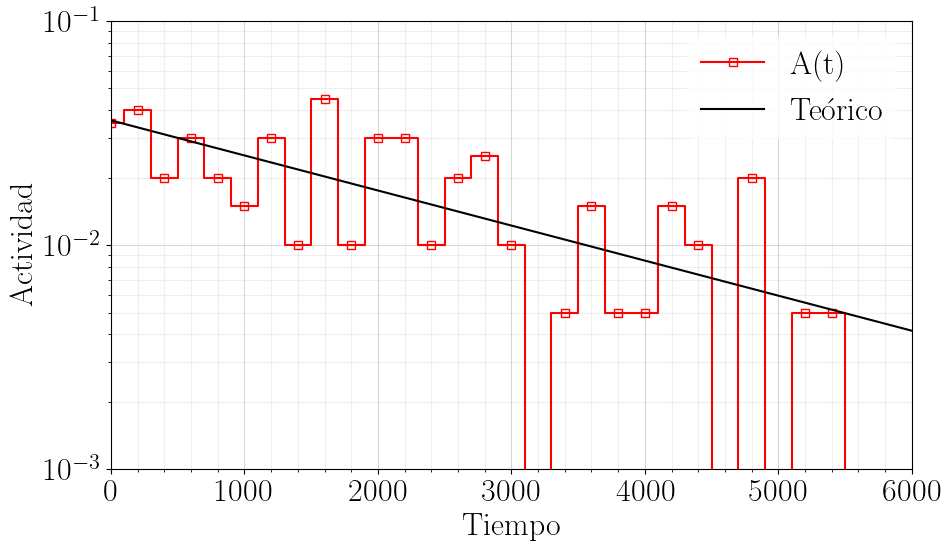

In [86]:
# Parámetros iniciales
N0 = 100  # Número inicial de núcleos
tau = 2775.68  # dias de vida media del Co-60.
delta_t = 200  # dias de intervalo de tiempo.

# Ejecutar la simulación
times, activities, nuclei_remaining, pmf_values, cdf_values = poisson_decay(
    N0, tau, delta_t
)

# Graficar resultados
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_ylim(0.001, 0.1)
ax.set_xlim(0, 6000)

# Gráfico de la actividad
ax.plot(times, activities, label="A(t)", marker="s", fillstyle="none", ds="steps-mid")

# Comparar con la curva teórica de actividad
theoretical_activity = N0 / tau * np.exp(-np.array(times) / tau)
ax.plot(times, theoretical_activity, label="Teórico", linestyle="-", color="black")
ax.set_ylabel("Actividad")
ax.set_xlabel("Tiempo")
ax.set_yscale("log")
ax.legend(frameon=True, edgecolor='none')
ax.grid(True, which="minor", alpha=0.2)

fig.tight_layout()
#fig.savefig("T4_nuclear_decay.png", dpi=300)
plt.show()

## T2
Luego, los parámetros resultan:
$$\tau = (2775.68 \pm 0.42) \, d$$


In [87]:
tau = 2775.68  # dias de vida media del Co-60.
delta_t = 1000  # dias de intervalo de tiempo.


## T4

Esto fue una prueba, no salio como se deseaba.

C:\Users\pinzo\AppData\Local\Temp\ipykernel_4816\760716709.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
C:\Users\pinzo\AppData\Local\Temp\ipykernel_4816\760716709.py:32: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


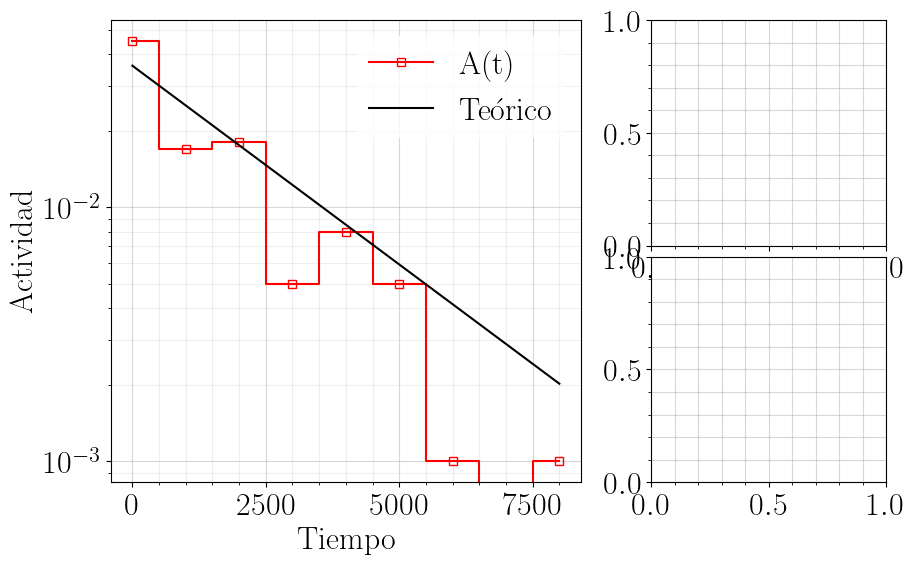

In [88]:
# Parámetros iniciales
N0 = 100  # Número inicial de núcleos

fig = plt.figure(constrained_layout=True, figsize=(10, 6))
axs = fig.subplot_mosaic([['Left', 'TopRight'], ['Left', 'BottomRight']],
                          gridspec_kw={'width_ratios': [2, 1], 'hspace': 0.05})  # Ajustar wspace para juntar los ejes

# Ejecutar la simulación
times, activities, nuclei_remaining, pmf_values, cdf_values = poisson_decay(
    N0, tau, delta_t
)

# Graficar resultados
#axs['Left'].set_ylim(0.9, 13)

# Gráfico de la actividad
axs['Left'].plot(times, activities, label="A(t)", marker="s", fillstyle="none", ds="steps-mid")

# Comparar con la curva teórica de actividad
theoretical_activity = N0 / tau * np.exp(-np.array(times) / tau)
axs['Left'].plot(times, theoretical_activity, label="Teórico", linestyle="-", color="black")
axs['Left'].set_ylabel("Actividad")
axs['Left'].set_xlabel("Tiempo")
axs['Left'].set_yscale("log")
axs['Left'].legend(frameon=True, edgecolor='none')
axs['Left'].grid(True, which="minor", alpha=0.2)

# Gráficas de la distribución de Poisson
#axs['TopRight'].bar(np.arange(0, N0 + 1), pmf_values[0], width=0.8, align='center')
#axs['BottomRight'].bar(np.arange(0, N0 + 1), pmf_values[0], width=0.8, align='center')

fig.tight_layout()
#fig.savefig("T4_nuclear_decay.png", dpi=300)
plt.show()

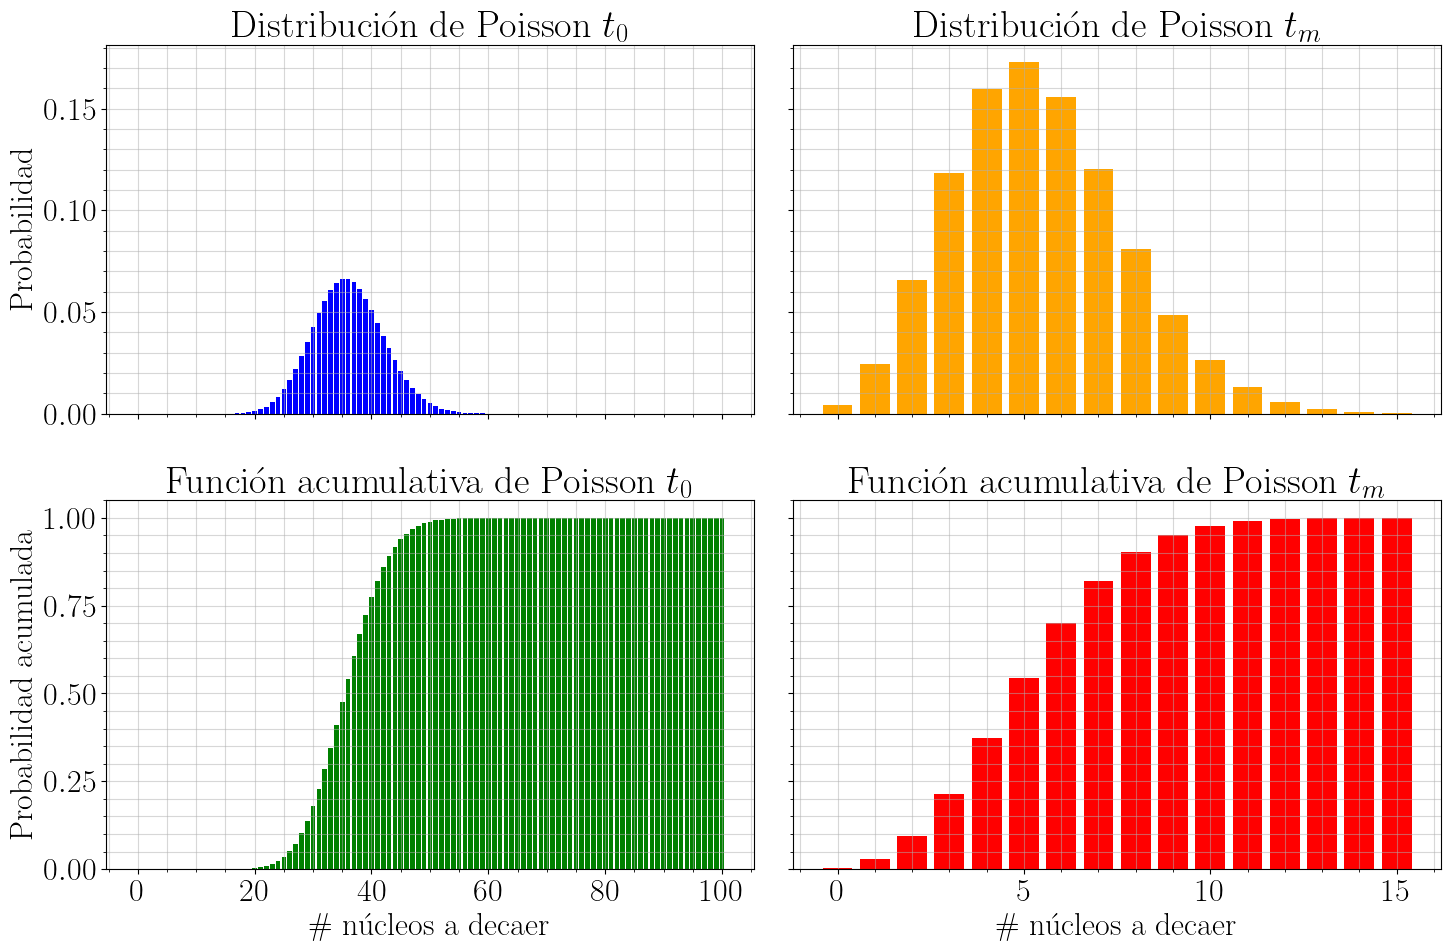

In [98]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex='col', sharey='row')

# Gráficas de la distribución de Poisson (pmf_values)
axs[0, 0].bar(range(len(pmf_values[0])), pmf_values[0], color='blue')
axs[0, 0].set_title('Distribución de Poisson $t_0$')
axs[0, 0].set_ylabel('Probabilidad')

axs[0, 1].bar(range(len(pmf_values[len(pmf_values)//2])), pmf_values[len(pmf_values)//2], color='orange')
axs[0, 1].set_title('Distribución de Poisson $t_m$')

# Gráficas de la función acumulativa de Poisson (cdf_values)
axs[1, 0].bar(range(len(cdf_values[0])), cdf_values[0], color='green')
axs[1, 0].set_title(r'Función acumulativa de Poisson $t_0$')
axs[1, 0].set_xlabel(r'\# núcleos a decaer')
axs[1, 0].set_ylabel('Probabilidad acumulada')

axs[1, 1].bar(range(len(cdf_values[len(cdf_values)//2])), cdf_values[len(cdf_values)//2], color='red')
axs[1, 1].set_title(r'Función acumulativa de Poisson $t_m$')
axs[1, 1].set_xlabel(r'\# núcleos a decaer')


plt.subplots_adjust(hspace=0)  # Ajustar el espacio entre subplots

plt.tight_layout()
plt.show()


## T5 y T6


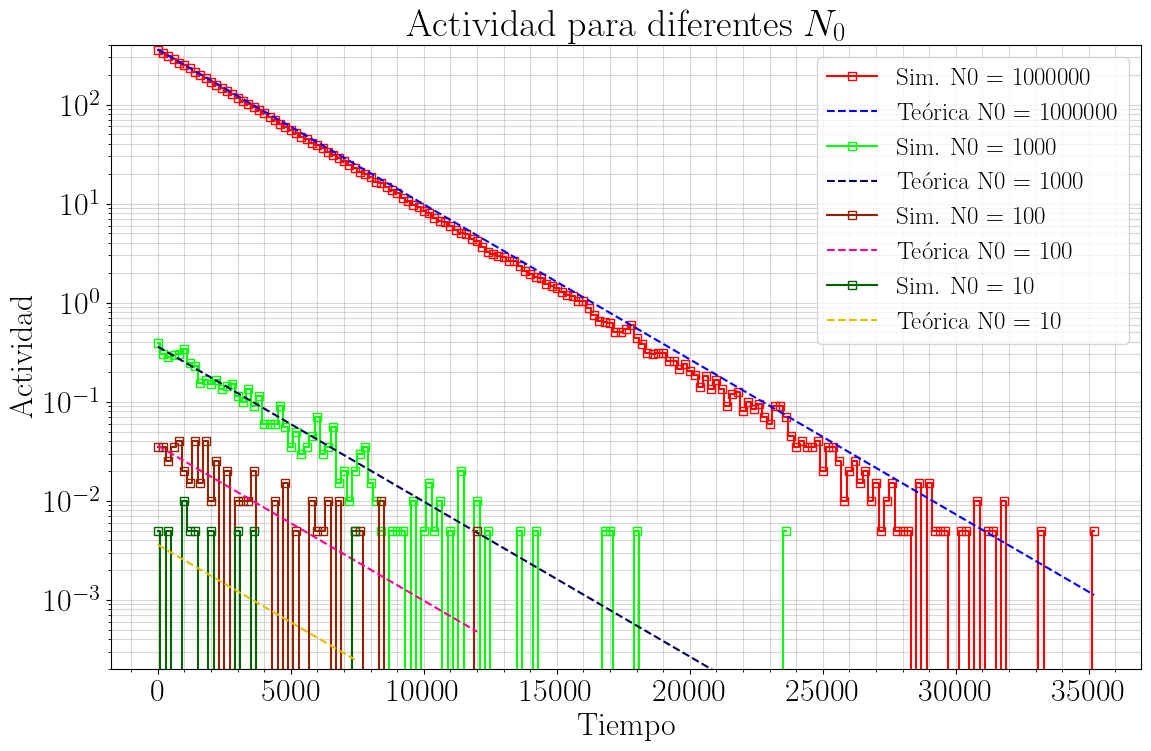

In [17]:
# Parámetros iniciales
N_values = [10**6, 10**3, 100, 10]  # Diferentes valores iniciales de núcleos

# Generar gráficos para los diferentes T en el archivo original
plt.figure(figsize=(12, 8))
plt.ylim(2e-4, 4e2)

for i, N0 in enumerate(N_values):
    times, activities, nuclei_remaining, _, _ = poisson_decay(N0, tau, delta_t)
    exponential_activity = [N0 / tau * np.exp(-t / tau) for t in times]

    # Gráfico de la actividad simulada, teórica y exponencial
    plt.plot(times, activities, label=f"Sim. N0 = {N0}", marker="s", fillstyle="none", ds="steps-mid")

    plt.plot(
        times, exponential_activity, linestyle="--", label=f"Teórica N0 = {N0}"
    )

plt.xlabel("Tiempo")
plt.ylabel("Actividad")
plt.title("Actividad para diferentes $N_0$")
plt.legend(fontsize=18)
plt.yscale("log")  # Escala semi-logarítmica


plt.tight_layout()
plt.savefig("grafica_T6_combined.png")  # Guardar la gráfica como archivo PNG
plt.show()
